# Google Trends Regression

This script will preprocess Google Trends data for Ukraine and run a regression with the
data provided from UNHCR

Author(s): Nathan Wykoff and Aidan Pizzo\
Last updated: March 17, 2023

In [1]:
import math
import os
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
#root = "./data/all_indicators/"
root = "./data/new_trends/all_indicators/"
dirnames = {
        'economic' :  'economic_indicators',
        'environment' :  'environment_indicators',
        'physical' :   'physical_indicators',
        'political' :  'political_indicators',
        'religion' :  'religion_indicators',
        'travel' :  'travel_indicators',
        'health' :  'health_insecurity_indicators',
        'food' :   'food_insecurity_indicators',
        }
OBLAST_MAP_PATH = '../../UkraineOblasts.csv'
UNHCR_DATA_PATH = './data/ukraine_displaced.csv'

In [3]:
trends = {}
for v in dirnames:
    dirr = root+'/'+dirnames[v]
    files = os.listdir(dirr)
# TODO: the file format for "old" indicators has duplicate dates which are messing things up.
#    if v in ['health','food']:
#

    adj_files = sorted([x for x in files if x.split('_')[-1] == 'adjusted.csv'])
    if v in ['health','food','religion']:
        dates = [pd.to_datetime(x.split('_')[2].split('-to-')) for x in adj_files]
    elif v in ['environment']:
        dates = [pd.to_datetime(x.split('_')[3].split('-to-')) for x in adj_files]
    elif v in ['economic', 'physical']:
        dates = [pd.to_datetime(x.split('_')[1].split('-to-')) for x in adj_files]
    elif v in ['political','travel']:
        dates = [pd.to_datetime(x.split('Words')[1].split('_')[0].split('-to-')) for x in adj_files]
    else:
        assert False
    #else:
    #    dd = [pd.to_datetime(x.split('_')[1].split('-to-')) for x in adj_files]
    dd = [(x[1] - x[0]).days for x in dates]
    is1 = [x==1 for x in dd]
    adj_files = [x for i,x in enumerate(adj_files) if is1[i]]
    dates = [x for i,x in enumerate(dates) if is1[i]]

    dfs = []
    for fi,f in enumerate(adj_files):
        df = pd.read_csv(dirr+'/'+f)
        ind = np.sum(df.iloc[:,10:], axis = 1)
        #if v in ['health','food']:
        #    date = f.split('_')[2].split('-to-')[0]
        #else:
        #    date = f.split('_')[1].split('-to-')[0]
        date = dates[fi][0]
        ind.index = pd.MultiIndex.from_tuples([(oblast, date) for oblast in df['geoName']], names = ['Oblast','Date'])
        dfs.append(ind)
    this_series = pd.concat(dfs)

    this_series.index.duplicated()

    trends[v] = pd.DataFrame(this_series, columns = [v])
    
trends_df = pd.concat(list(trends.values()), axis = 1)
trends_df.columns = list(trends.keys())
trends_df.index.names = ['oblast','date']

In [4]:
# map oblast to macro-region
oblast_map = pd.read_csv(OBLAST_MAP_PATH)

# load UNHCR dataframe
unhcr_df = pd.read_csv(UNHCR_DATA_PATH)

# convert dates in UNHCR dataframe
unhcr_df['date_to'] = pd.to_datetime(unhcr_df['date_to'])
unhcr_df['date_from'] = pd.to_datetime(unhcr_df['date_from'])

In [5]:
trends_df.head

<bound method NDFrame.head of                                   economic  environment   physical  political  \
oblast                date                                                      
Cherkas'ka oblast     2022-01-01  2.437680     1.127927   6.396952   2.612080   
Chernihivs'ka oblast  2022-01-01  1.869123     1.132070   7.757092   4.405690   
Chernivets'ka oblast  2022-01-01  1.811772     1.190165   5.318920   2.513461   
Crimea                2022-01-01  1.322550     1.166118   2.617029   1.943866   
Dnipropetrovsk Oblast 2022-01-01  1.906919     1.160881   4.603711   2.334321   
...                                    ...          ...        ...        ...   
Vinnyts'ka oblast     2022-09-01  3.953926     1.199909  10.842672   4.870587   
Volyns'ka oblast      2022-09-01  5.517581     1.264774  14.441337   8.567168   
Zakarpats'ka oblast   2022-09-01  3.278265     1.163827   9.410222   7.197828   
Zaporiz'ka oblast     2022-09-01  3.443748     1.223937   5.509224   5.204451  

In [6]:
trends_df.reset_index(inplace=True)
# Drop crimean oblasts
ind = trends_df[(trends_df['oblast'] == 'Crimea')].index
trends_df.drop(ind, inplace=True)
ind = trends_df[(trends_df['oblast'] == 'Sevastopol\' city')].index
trends_df.drop(ind, inplace=True)
# Convert dates to datetime objects
trends_df['date'] = pd.to_datetime(trends_df.loc[:, 'date'], format="%Y%m%d")

In [7]:
# Oblast mapping with provided file, create dictionary mapping with relevant rows
# Create dictionary to map oblast code to macroregion
mapping_df = oblast_map[oblast_map['alias'].apply(str.lower).isin(trends_df['oblast'].drop_duplicates().apply(str.lower))]
oblastToRegion = dict(zip(mapping_df['alias'].apply(str.lower), mapping_df['macroregion']))
trends_df['Macro-region'] = trends_df['oblast'].apply(str.lower).apply(lambda x: oblastToRegion[x])

In [8]:
# Aggregate macroregions, sum variable values
trends_df.groupby(['Macro-region', 'date']).sum()

economic  environment   physical  political  \
Macro-region date                                                       
Center       2022-01-01  10.153316     4.524829  25.089305  11.399520   
             2022-01-02  10.192238     4.601271  22.969388  12.241445   
             2022-01-03  10.968618     4.605028  24.784711  17.355850   
             2022-01-04  11.378340     4.613912  24.839512  21.133879   
             2022-01-05   9.182768     4.578711  20.124096  16.952864   
...                            ...          ...        ...        ...   
West         2022-08-28  31.831494     9.323578  92.062984  45.164966   
             2022-08-29  29.489168     9.326370  83.775130  51.087863   
             2022-08-30  28.161036     9.600750  86.018127  59.209725   
             2022-08-31  31.634939     9.485603  90.006963  53.620532   
             2022-09-01  31.878136     9.416640  86.945280  55.831799   

                         religion     travel     health       food  
Macro-region date                                                   
Center       2022-01-01  2.642445   3.283887   4.795607   5.987112  
             2022-01-02  2.265523   3.153391   4.385111   5.813092  
             2022-01-03  2.805227   3.734982   5.948950   7.348771  
             2022-01-04  2.660753   3.688209   6.082798   7.200107  
             2022-01-05  3.547643   2.822194   4.272700   6.135751  
...                           ...        ...        ...        ...  
West         2022-08-28  4.267217  11.828569  13.629376  29.570907  
             2022-08-29  3.355009  12.118719  12.284379  27.554743  
             2022-08-30  3.203313  10.408113  11.444355  27.866124  
             2022-08-31  2.679062  10.402778  13.520528  28.811694  
             2022-09-01  3.769462   8.179654  12.474740  27.035164  

[1464 rows x 8 columns]

In [9]:
# Aggregate over time periods from UNHCR data
intervals = unhcr_df[['date_from', 'date_to', 'period_length']].drop_duplicates()
# Create empty data frame with column names to add date-aggregated data
final_df = pd.DataFrame(columns=['economic',
                                 'environment',
                                 'physical',
                                 'political',
                                 'religion',
                                 'travel',
                                 'health',
                                 'food'])

"""
Create list of tuple date ranges,
iterate through each of the date ranges and create a dataframe containing data in that range,
aggregate data across dates, taking mean of all variables values while grouping by Macro-region,
add date-aggregated to final dataframe
"""
ranges = list(intervals.itertuples(index=False, name=None))
for drange in ranges:
    events_date_range = trends_df[(trends_df['date'] >= drange[0]) & (trends_df['date'] < drange[1])]
    events_date_range = events_date_range.groupby('Macro-region').mean()
    events_date_range = events_date_range.reset_index()
    events_date_range['date_from'] = drange[0]
    events_date_range['date_to'] = drange[1]
    frames = [final_df, events_date_range]
    final_df = pd.concat(frames)

In [10]:
# Make Multi-index before running regression (Macro-region and date_to)
final_df.index = final_df['Macro-region'] + '-' + final_df['date_to'].astype(str)
unhcr_df.index = unhcr_df['Macro-region'] + '-' + unhcr_df['date_to'].astype(str)

In [11]:
final_df
final_df.drop(['date_to', 'date_from', 'Macro-region'], axis=1).to_csv('trends_vars.csv')

### Exploratory Data Analysis

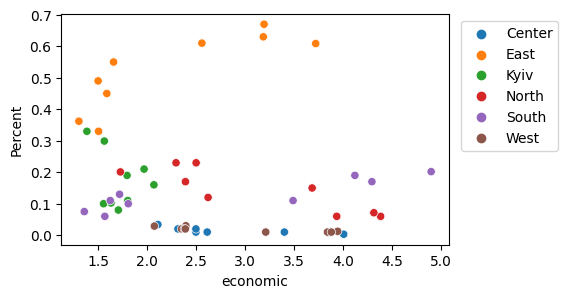

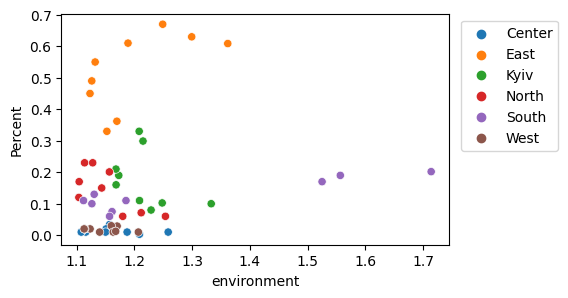

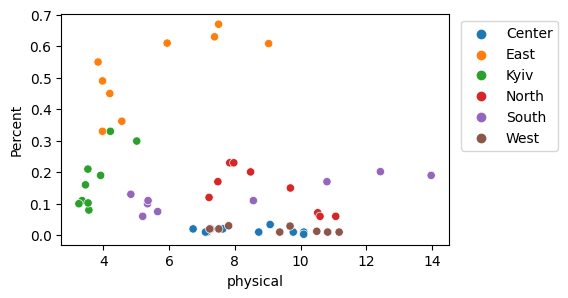

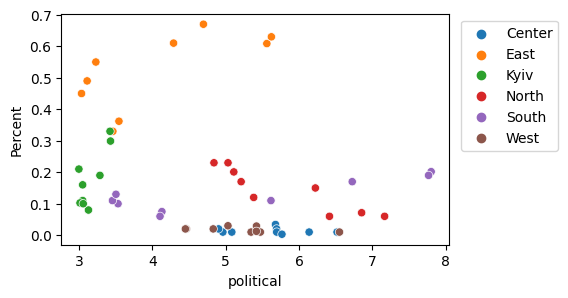

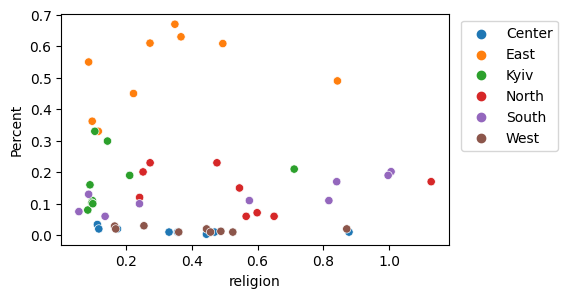

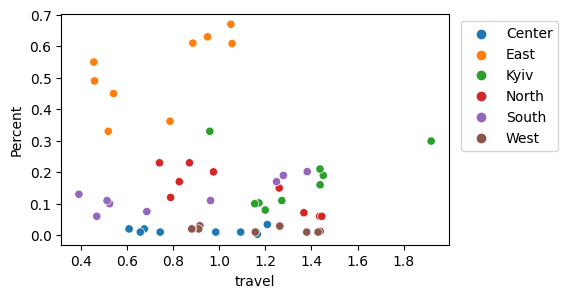

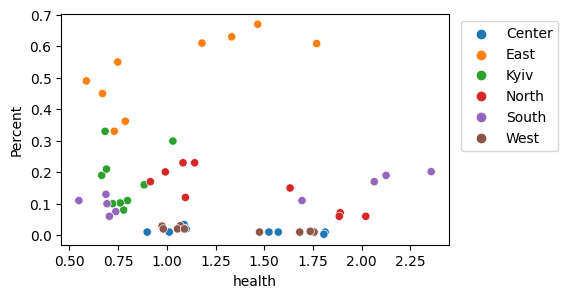

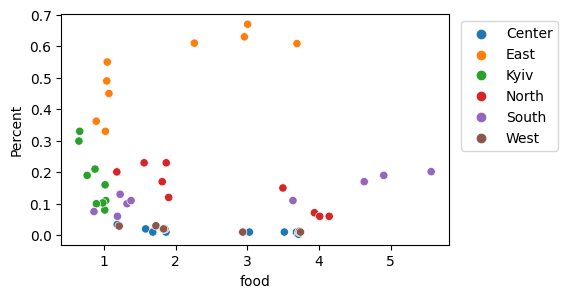

In [12]:
# variable values vs the flow percentage
for column in final_df.columns[0:8]:
    plt.figure(figsize=(5,3))
    sns.scatterplot(x=final_df[column], y=unhcr_df['Percent'], hue=unhcr_df['Macro-region'])
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')

### Log10 Transformation

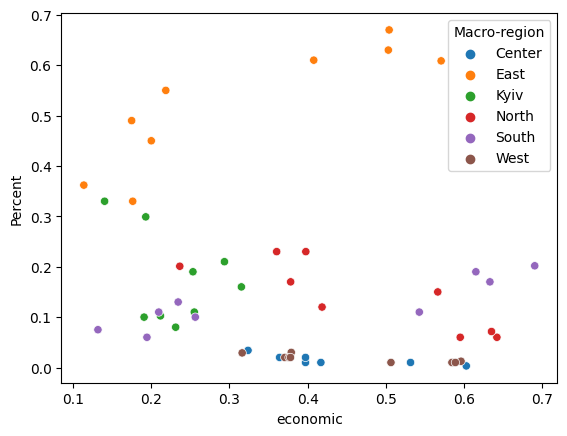

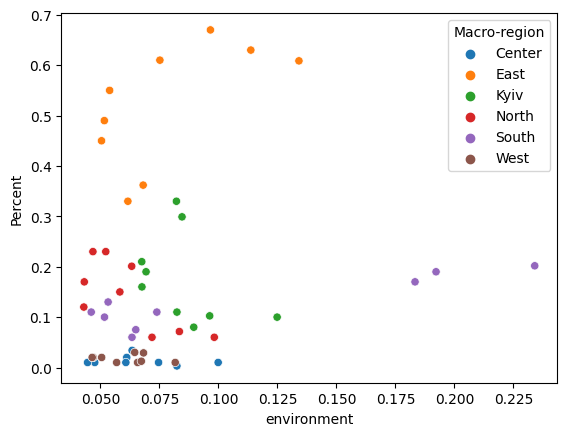

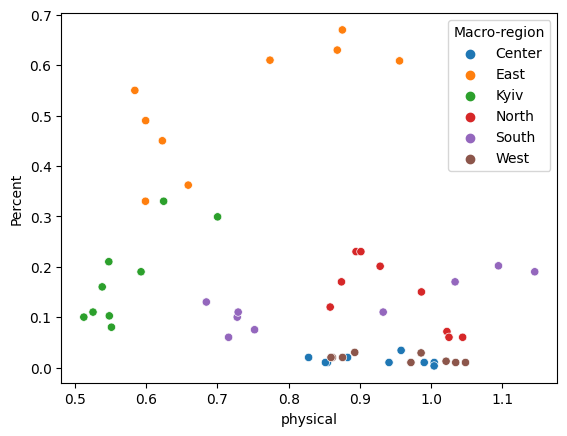

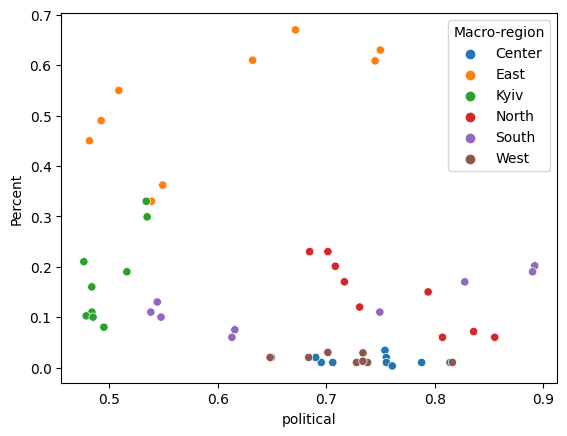

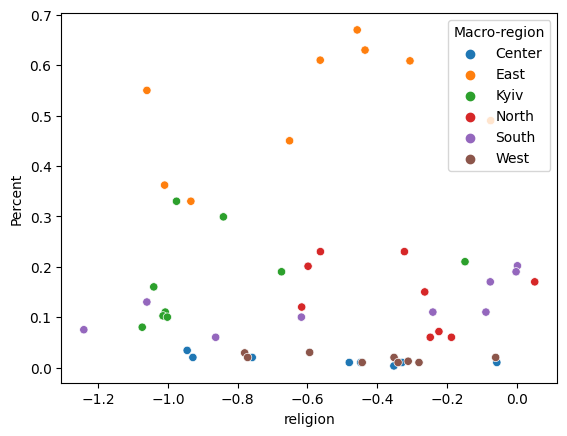

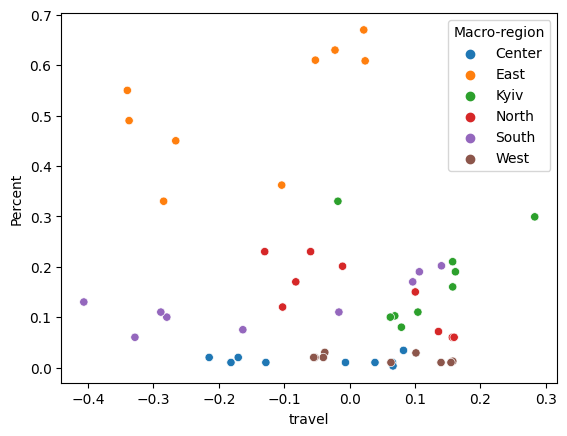

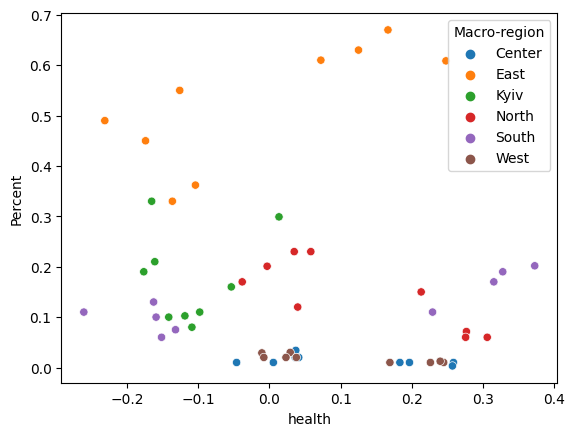

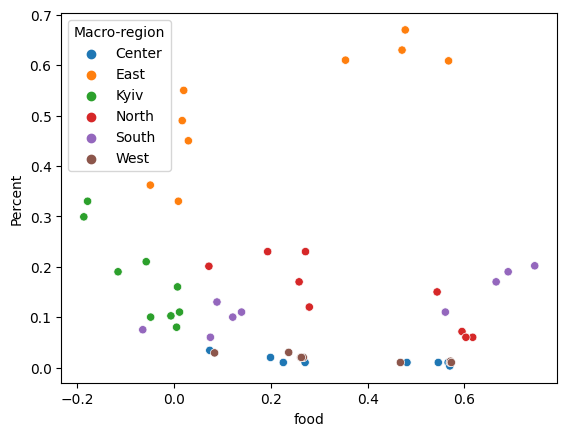

In [13]:
log_df = final_df.copy()
for column in log_df.columns[0:8]:
    log_df[column] = log_df[column].apply(lambda x: math.log10(x))
    plt.figure()
    sns.scatterplot(x=log_df[column], y=unhcr_df['Percent'], hue=unhcr_df['Macro-region'])

In [14]:
# drop rows of UNHCR data from date range
drop_ind = unhcr_df[unhcr_df.date_to == '2022-10-27'].index
unhcr_df.drop(drop_ind, inplace=True)

### Regression

economic

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     3.412
Date:                Wed, 12 Apr 2023   Prob (F-statistic):             0.0704
Time:                        09:47:12   Log-Likelihood:                 16.786
No. Observations:                  54   AIC:                            -29.57
Df Residuals:                      52   BIC:                            -25.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2867      0.069      4.13

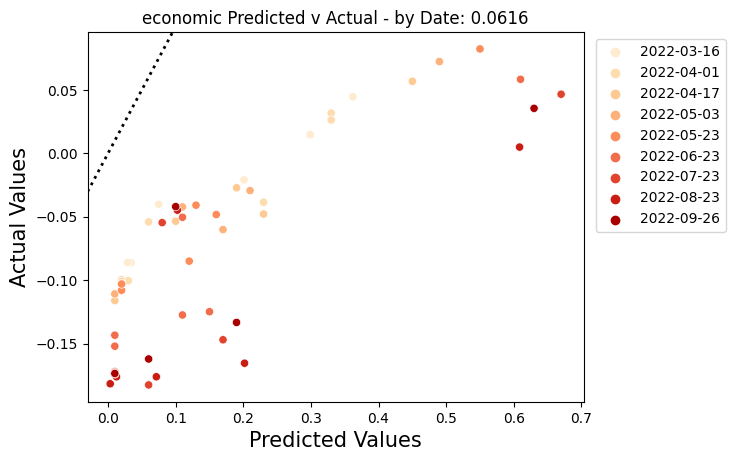

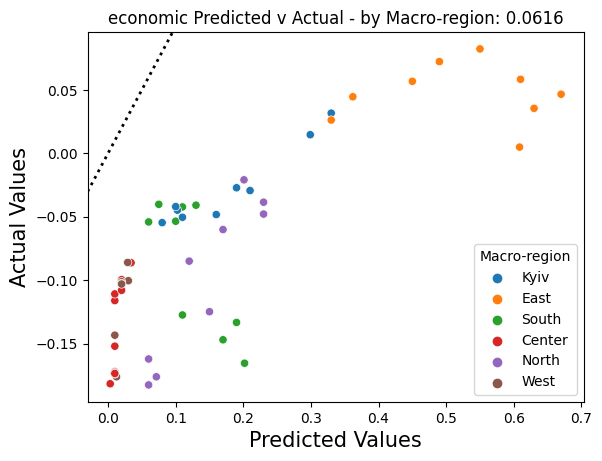




environment

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                   0.06024
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.807
Time:                        09:47:13   Log-Likelihood:                 15.101
No. Observations:                  54   AIC:                            -26.20
Df Residuals:                      52   BIC:                            -22.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1015      0.268    

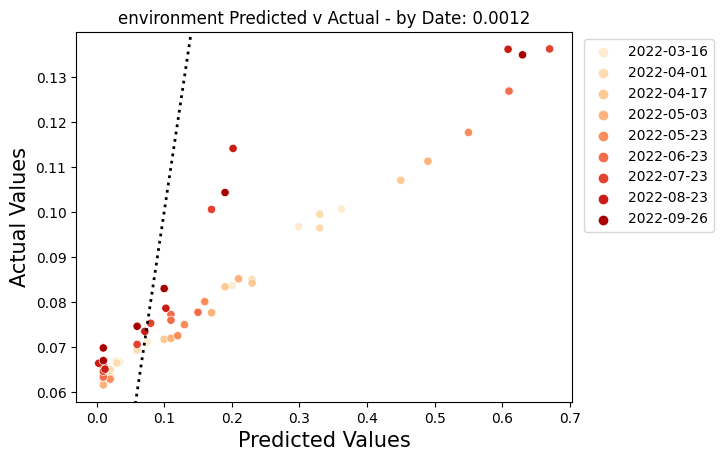

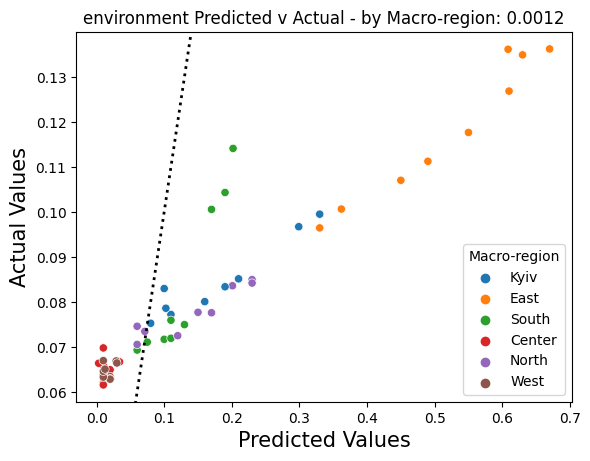




physical

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     8.240
Date:                Wed, 12 Apr 2023   Prob (F-statistic):            0.00591
Time:                        09:47:14   Log-Likelihood:                 19.041
No. Observations:                  54   AIC:                            -34.08
Df Residuals:                      52   BIC:                            -30.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3498      0.068      5

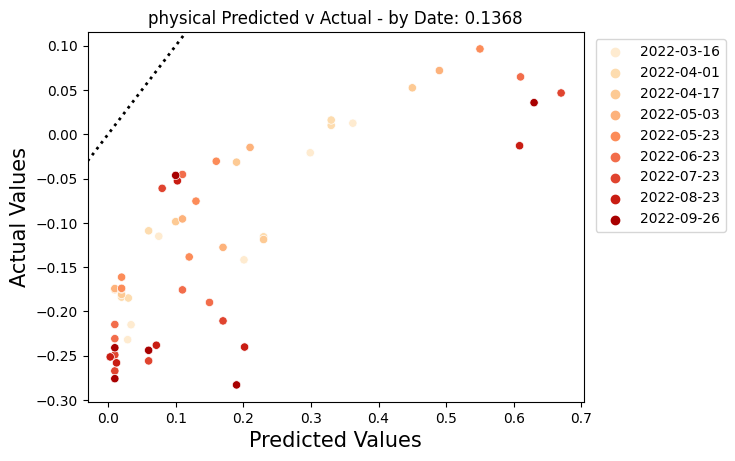

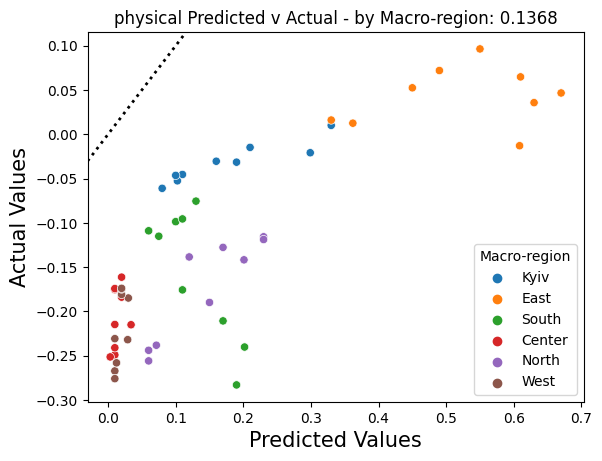




political

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     5.722
Date:                Wed, 12 Apr 2023   Prob (F-statistic):             0.0204
Time:                        09:47:16   Log-Likelihood:                 17.889
No. Observations:                  54   AIC:                            -31.78
Df Residuals:                      52   BIC:                            -27.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3781      0.092      

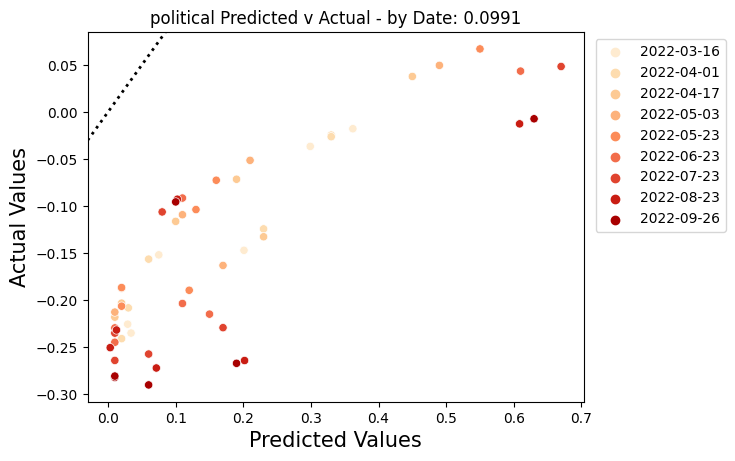

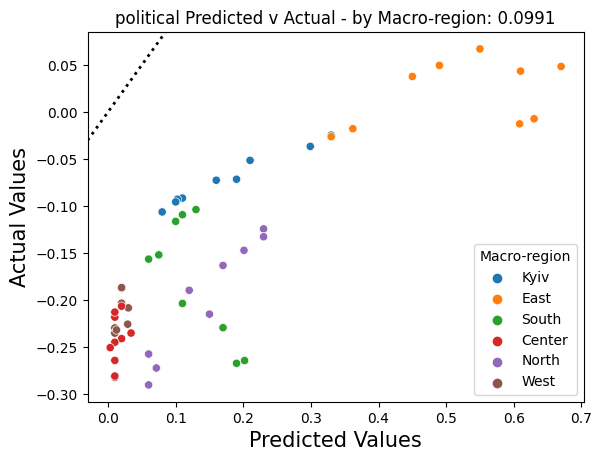




religion

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.486
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.121
Time:                        09:47:17   Log-Likelihood:                 16.331
No. Observations:                  54   AIC:                            -28.66
Df Residuals:                      52   BIC:                            -24.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2210      0.042      5

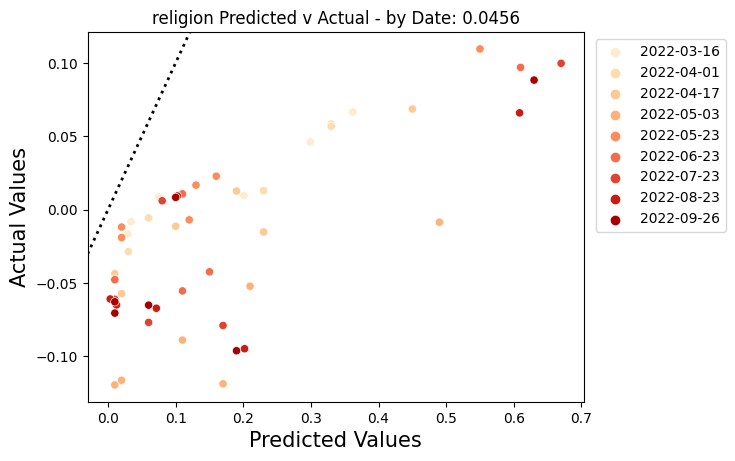

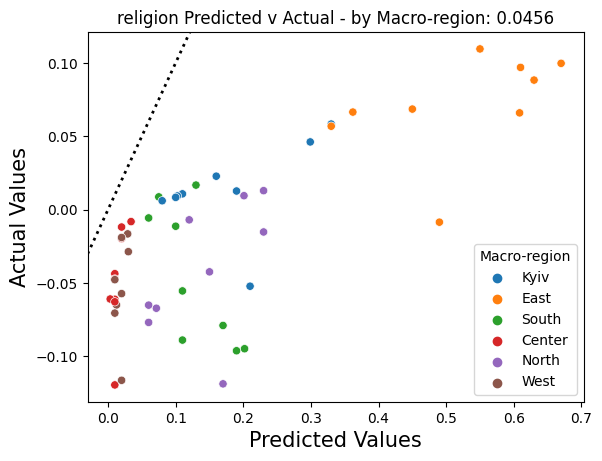




travel

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     10.06
Date:                Wed, 12 Apr 2023   Prob (F-statistic):            0.00254
Time:                        09:47:18   Log-Likelihood:                 19.844
No. Observations:                  54   AIC:                            -35.69
Df Residuals:                      52   BIC:                            -31.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3873      0.073      5.2

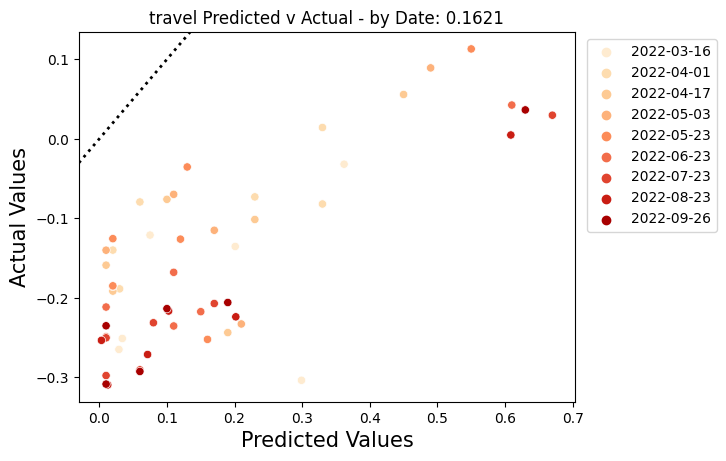

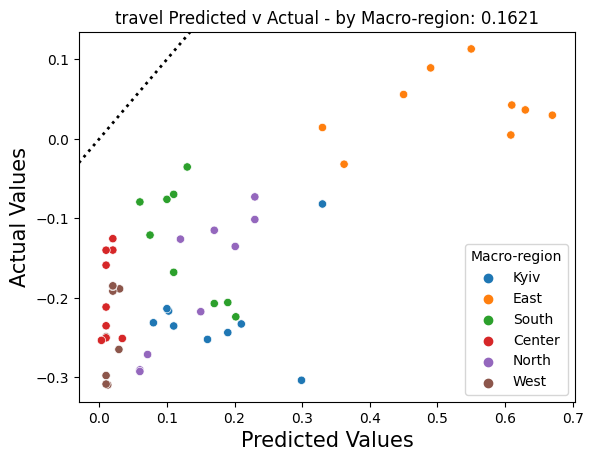




health

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3.158
Date:                Wed, 12 Apr 2023   Prob (F-statistic):             0.0814
Time:                        09:47:19   Log-Likelihood:                 16.662
No. Observations:                  54   AIC:                            -29.32
Df Residuals:                      52   BIC:                            -25.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2770      0.067      4.1

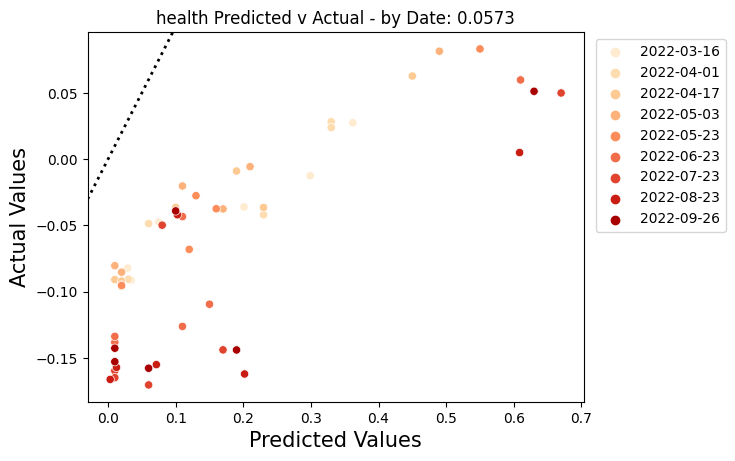

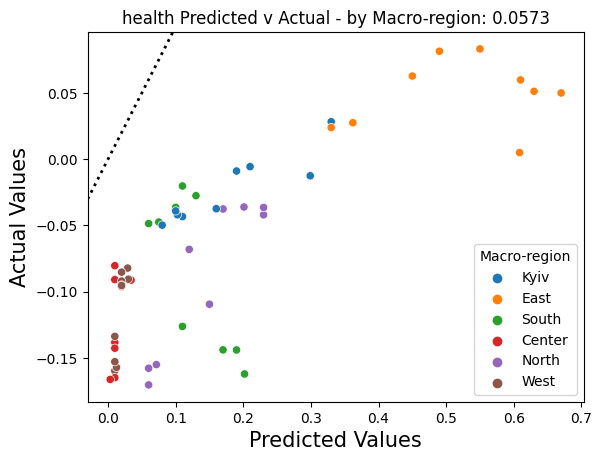




food

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.960
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.167
Time:                        09:47:20   Log-Likelihood:                 16.069
No. Observations:                  54   AIC:                            -28.14
Df Residuals:                      52   BIC:                            -24.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2260      0.049      4.605

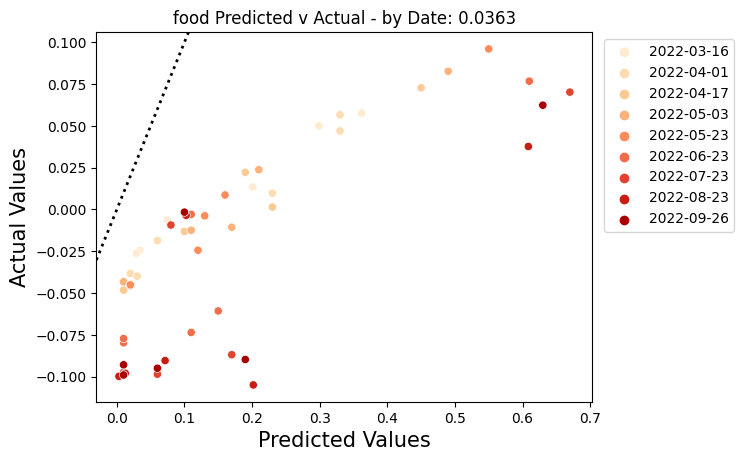

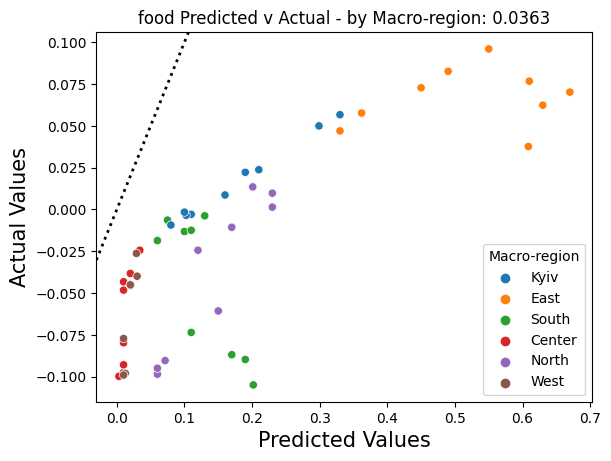

In [15]:
# build regression model for each trends variable
for column in final_df.columns[0:8]:
    Y = unhcr_df['Percent']
    X = final_df[column]
    model = sm.OLS(np.array(Y.astype(float)), sm.add_constant(np.array(X.astype(float))))
    fit = model.fit()
    print(column + "\n")
    print(fit.summary())
    print("\n")
    print('R-squared: ', fit.rsquared)
    print("\n")
    
    # predictions vs actual values plot, colored by date
    predictions = fit.predict(pd.concat([unhcr_df['Percent'], final_df[column]], axis=1))
    plt.title(column + " Predicted v Actual - by Date: " + str('%.4f'%(fit.rsquared)))
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15)
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['date_to'].dt.date, palette='OrRd') # add style=unhcr_df['Macro-region'] for shape by Macro-region or vice versa
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
    #plt.scatter(predictions, unhcr_df['Percent'], c=unhcr_df.date_to, cmap='OrRd')
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    # predictions vs actual values plot, colored by Macro-region
    plt.title(column + " Predicted v Actual - by Macro-region: " + str('%.4f'%(fit.rsquared)))
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15)
    #colors = {'Kyiv':'red', 'East':'green', 'South':'blue', 'Center':'yellow', 'North':'purple', 'West':'orange'}
    #plt.scatter(predictions, unhcr_df['Percent'], c=unhcr_df['Macro-region'].map(colors))
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['Macro-region'])
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
    #plt.legend(labels=unhcr_df['Macro-region'])
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    print("\n\n")

### Lag/Lead

In [16]:
# for each lag/lead interval, aggregate by date range and add to df with all lag/lead data
lag_df = pd.DataFrame(columns=['economic',
                                 'environment',
                                 'physical',
                                 'political',
                                 'religion',
                                 'travel',
                                 'health',
                                 'food'])
for i in range(-24,25):
    ranges = list(intervals.itertuples(index=False, name=None))
    for drange in ranges:
        lag = timedelta(days = i)
        events_date_range = trends_df[(trends_df['date'] >= drange[0] + lag) & (trends_df['date'] < drange[1] + lag)]
        events_date_range = events_date_range.groupby('Macro-region').mean()
        events_date_range = events_date_range.reset_index()
        events_date_range['date_from'] = drange[0]
        events_date_range['date_to'] = drange[1]
        events_date_range['lag'] = int(i)
        frames = [lag_df, events_date_range]
        lag_df = pd.concat(frames)

In [17]:
# create regression models, add r squared for each lag and variable to table
r_squared_df = pd.DataFrame(columns=['lag',
                                 'variable',
                                 'r_squared'])
for i in range(-24,10):
    temp_df = lag_df[lag_df['lag']==i]
    for column in lag_df.columns[0:8]:
        Y = unhcr_df['Percent']
        X = temp_df[column]
        model = sm.OLS(np.array(Y.astype(float)), sm.add_constant(np.array(X.astype(float))))
        fit = model.fit()
        r_squared_df.loc[len(r_squared_df.index)] = [i, column, fit.rsquared]
        
# Google trends data only goes up to 9/1, so for a 10+ day lag, there is one less date range
unhcr_df_ed = unhcr_df.drop(unhcr_df[unhcr_df.date_to == '2022-9-26'].index)
for i in range(10,24):
    temp_df = lag_df[lag_df['lag']==i]
    for column in lag_df.columns[0:8]:
        Y = unhcr_df_ed['Percent']
        X = temp_df[column]
        model = sm.OLS(np.array(Y.astype(float)), sm.add_constant(np.array(X.astype(float))))
        fit = model.fit()
        r_squared_df.loc[len(r_squared_df.index)] = [i, column, fit.rsquared]
        
#r_squared_df.set_index(['lag', 'variable'], inplace=True)

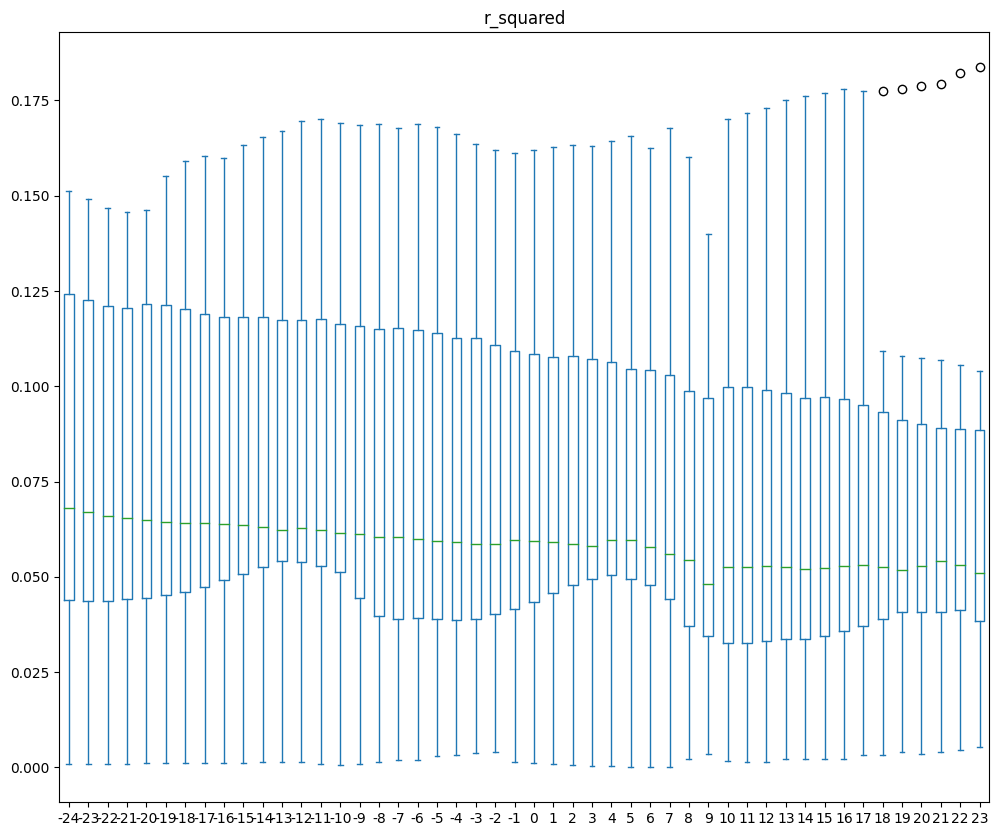

In [18]:
ax = r_squared_df.plot.box(by="lag", figsize=(12, 10))
# downward tip around values of 9 - maybe because at 10+ there is one less date range?

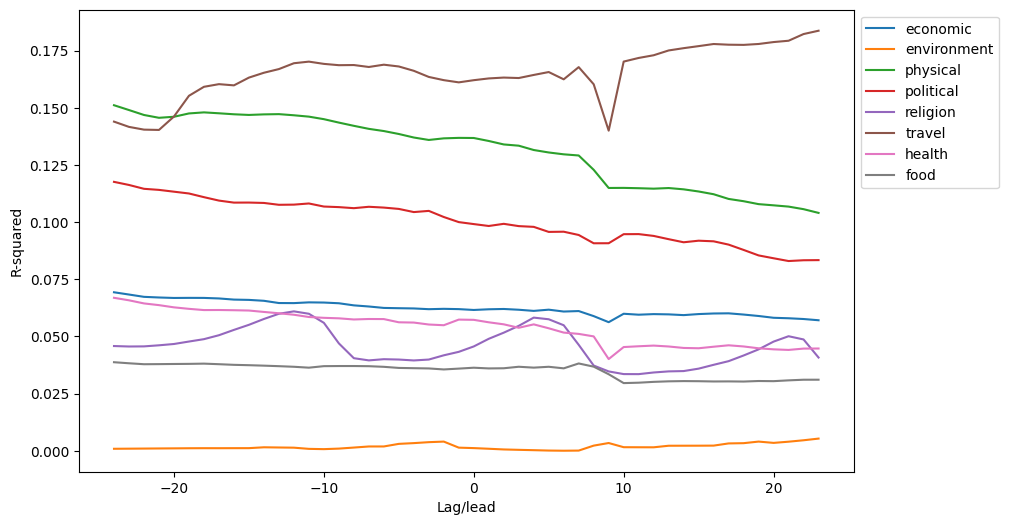

In [19]:
plt.figure(figsize=(10,6))
for column in lag_df.columns[0:8]:
    temp_df = r_squared_df[r_squared_df['variable']==column]
    plt.plot(temp_df['lag'], temp_df['r_squared'], label=column)
   
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Lag/lead")
plt.ylabel("R-squared")
plt.show()

### Modeling with dummy variables (untransformed data)

economic

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     51.86
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           4.48e-19
Time:                        09:47:27   Log-Likelihood:                 69.902
No. Observations:                  54   AIC:                            -125.8
Df Residuals:                      47   BIC:                            -111.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0120      0.011     -1.07

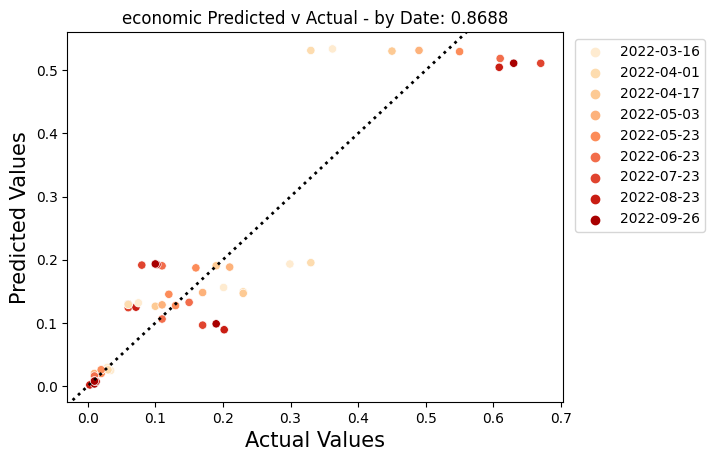

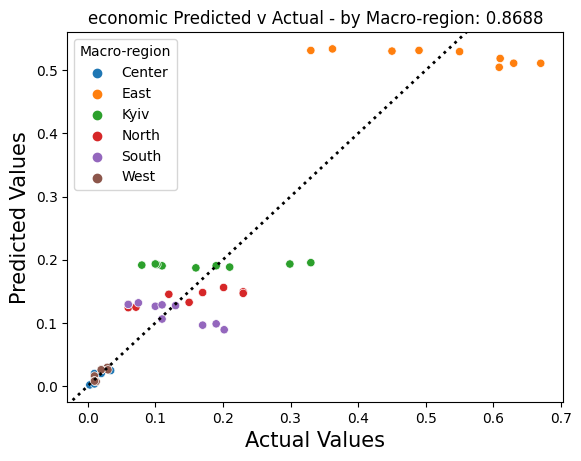




environment

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     52.07
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           4.12e-19
Time:                        09:47:28   Log-Likelihood:                 69.999
No. Observations:                  54   AIC:                            -126.0
Df Residuals:                      47   BIC:                            -112.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1092      0.095    

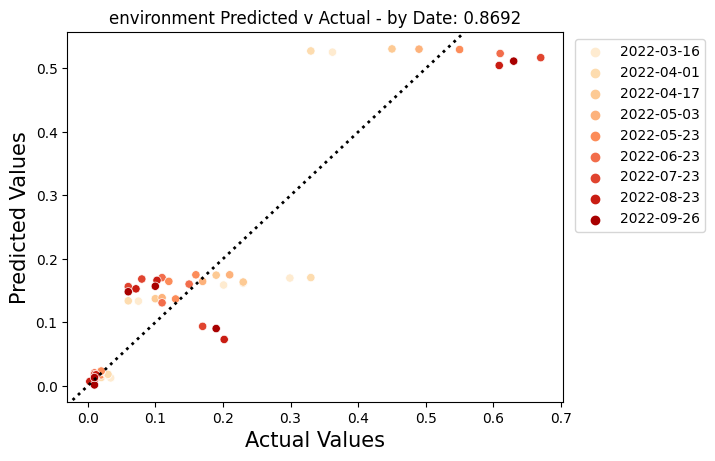

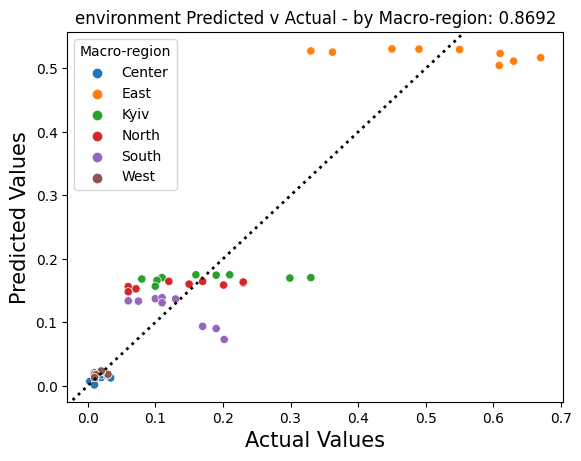




physical

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     51.76
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           4.65e-19
Time:                        09:47:29   Log-Likelihood:                 69.858
No. Observations:                  54   AIC:                            -125.7
Df Residuals:                      47   BIC:                            -111.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0054      0.005     -1

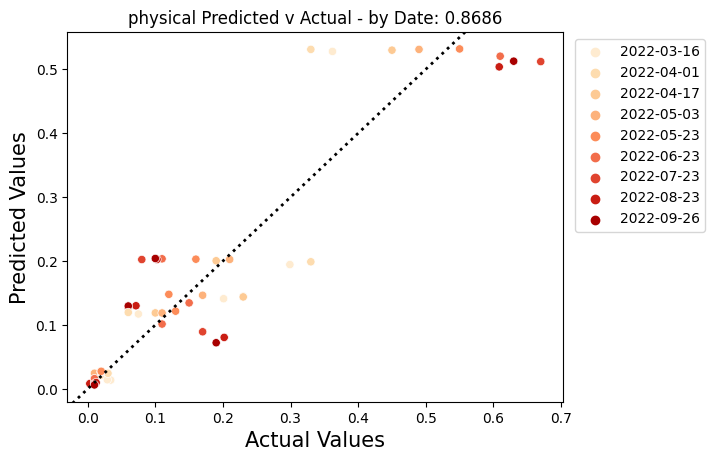

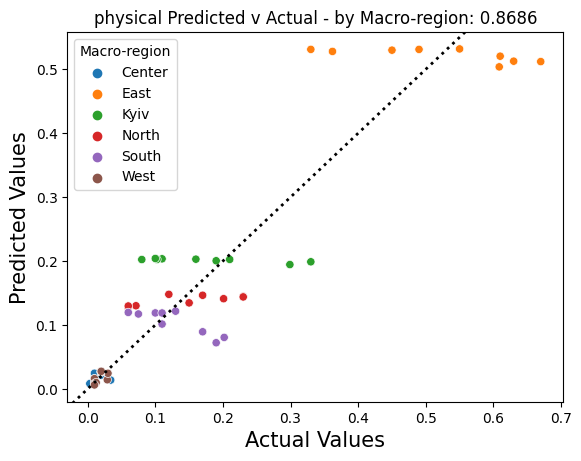




political

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     51.14
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           5.93e-19
Time:                        09:47:29   Log-Likelihood:                 69.576
No. Observations:                  54   AIC:                            -125.2
Df Residuals:                      47   BIC:                            -111.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0078      0.010     -

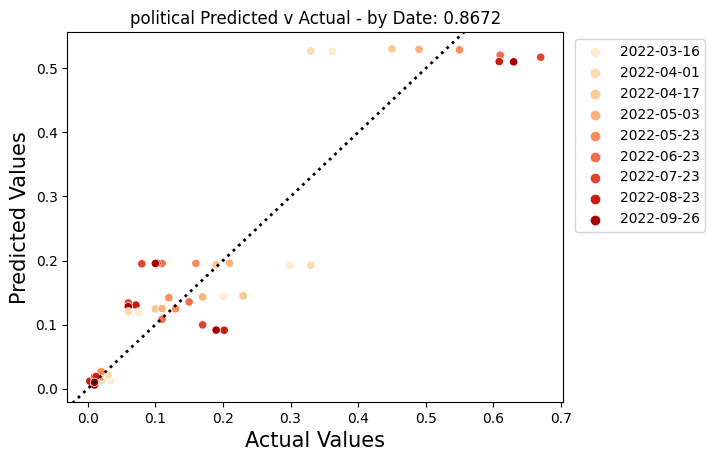

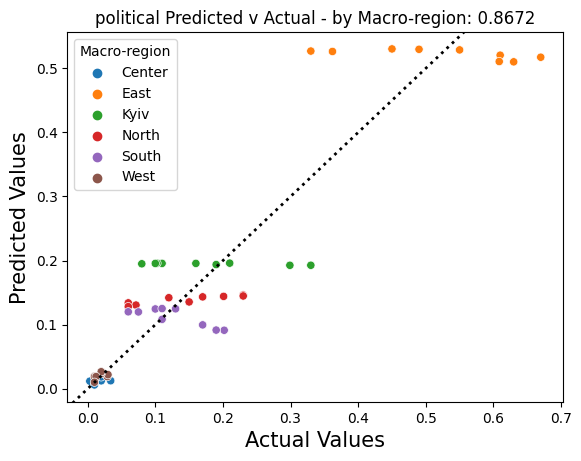




religion

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     52.83
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           3.09e-19
Time:                        09:47:30   Log-Likelihood:                 70.336
No. Observations:                  54   AIC:                            -126.7
Df Residuals:                      47   BIC:                            -112.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0520      0.037     -1

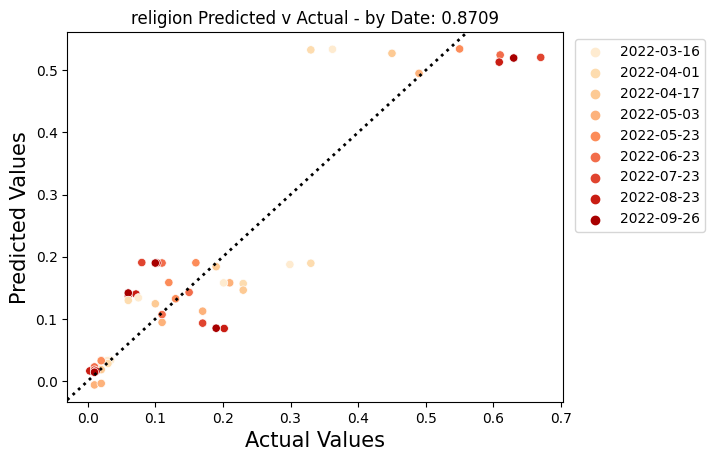

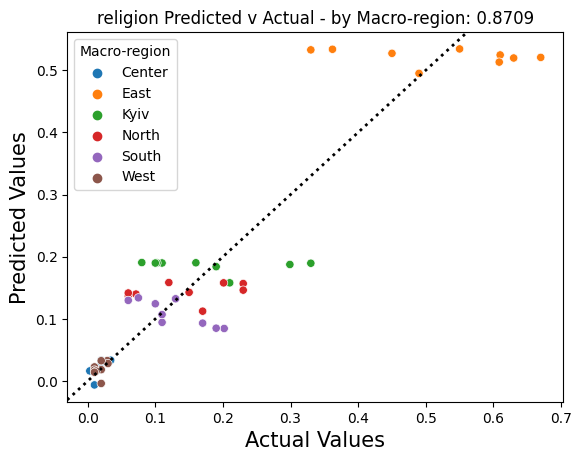




travel

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     51.65
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           4.85e-19
Time:                        09:47:31   Log-Likelihood:                 69.809
No. Observations:                  54   AIC:                            -125.6
Df Residuals:                      47   BIC:                            -111.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0354      0.036     -0.9

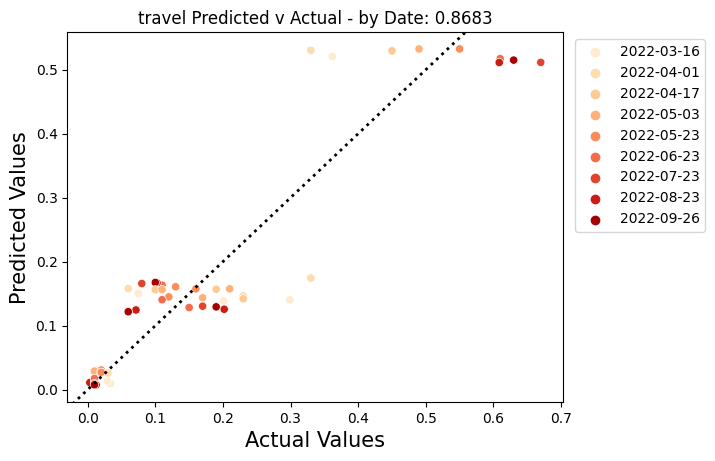

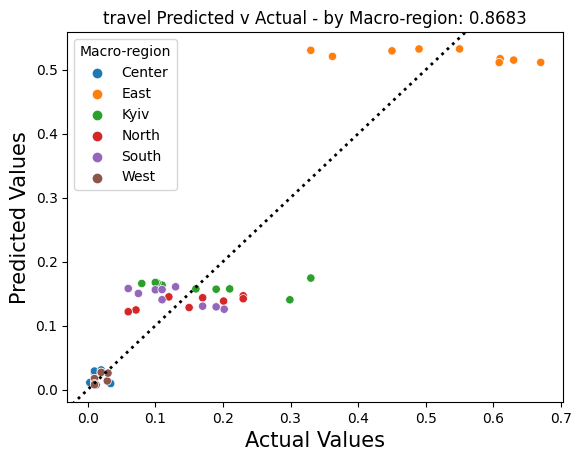




health

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     52.51
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           3.49e-19
Time:                        09:47:31   Log-Likelihood:                 70.193
No. Observations:                  54   AIC:                            -126.4
Df Residuals:                      47   BIC:                            -112.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0296      0.023     -1.2

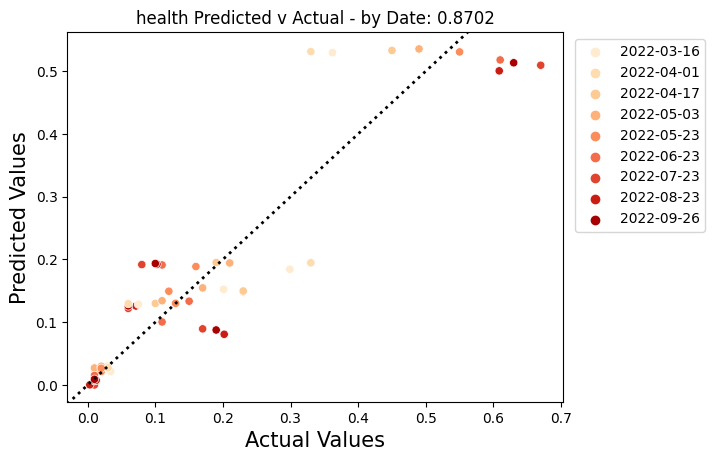

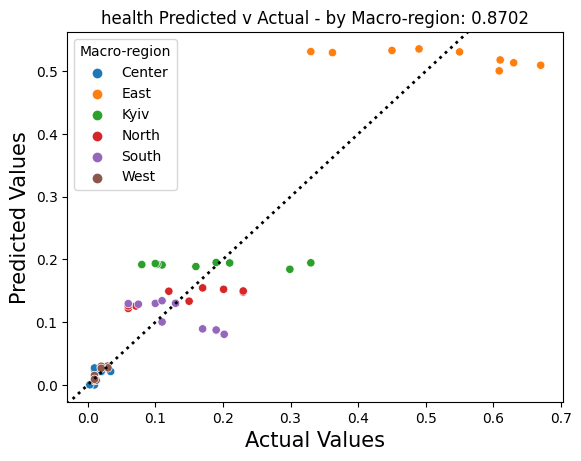




food

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     52.60
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           3.36e-19
Time:                        09:47:32   Log-Likelihood:                 70.236
No. Observations:                  54   AIC:                            -126.5
Df Residuals:                      47   BIC:                            -112.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0114      0.009     -1.325

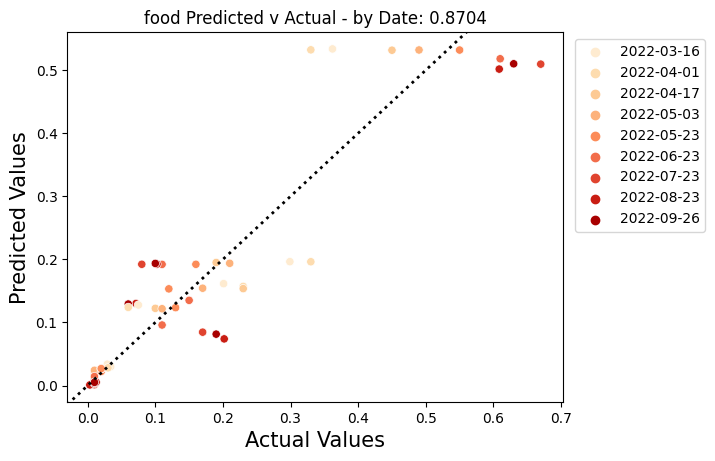

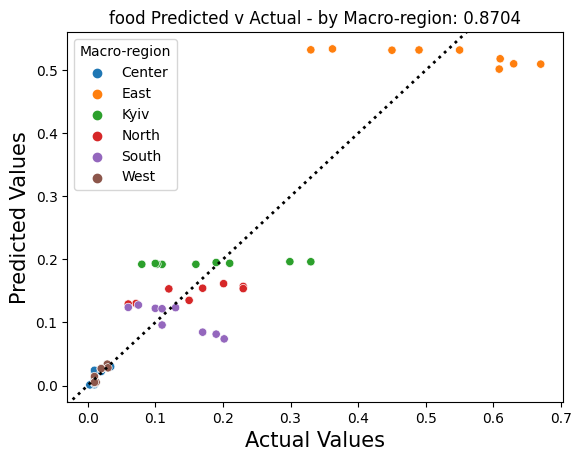

In [20]:
rsquared_list = []

# build regression model for each GDELT events variable
for column in final_df.columns[0:8]:
    Y = np.asarray(unhcr_df['Percent'].astype(float))
    X = np.asarray(final_df[[column]].astype(float))
    
    # build model without dummy variables
    #X = sm.add_constant(X)
    
    
    # dummy variables for macroregion - drop_first = True
    X = np.concatenate([X, pd.get_dummies(unhcr_df['Macro-region'])], axis=1)
    
    model = sm.OLS(Y, X)
    #Fitting model
    results = model.fit()
    #Saving the r_square value
    rsquared_list.append(results.rsquared)
    
    print(column + "\n")
    print(results.summary())
    print("\n")
    print('R-squared: ', results.rsquared)
    print("\n")
    
    # predictions vs actual values plot, colored by date
    predictions = results.predict(pd.concat([final_df[[column]], pd.get_dummies(unhcr_df['Macro-region'])], axis=1))
    plt.title(column + " Predicted v Actual - by Date: " + str('%.4f'%(results.rsquared)))
    plt.xlabel('Actual Values', fontsize=15)
    plt.ylabel('Predicted Values', fontsize=15)
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['date_to'].dt.date, palette='OrRd') # add style=unhcr_df['Macro-region'] for shape by Macro-region or vice versa
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
    #plt.scatter(unhcr_df['Percent'], predictions, c=unhcr_df.date_to, cmap='OrRd')
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    # predictions vs actual values plot, colored by Macro-region
    plt.title(column + " Predicted v Actual - by Macro-region: " + str('%.4f'%(results.rsquared)))
    plt.xlabel('Actual Values', fontsize=15)
    plt.ylabel('Predicted Values', fontsize=15)
    #colors = {'Kyiv':'red', 'East':'green', 'South':'blue', 'Center':'yellow', 'North':'purple', 'West':'orange'}
    #plt.scatter(unhcr_df['Percent'], predictions, c=unhcr_df['Macro-region'].map(colors))
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['Macro-region'])
    #plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
    #g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    #plt.legend(['Kyiv','East','South','Center','North','West'])
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    print("\n\n")

### Closer look at West and Center Macro-regions

economic

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     13.32
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           0.000472
Time:                        09:47:33   Log-Likelihood:                 69.936
No. Observations:                  18   AIC:                            -133.9
Df Residuals:                      15   BIC:                            -131.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0088      0.002     -4.94

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


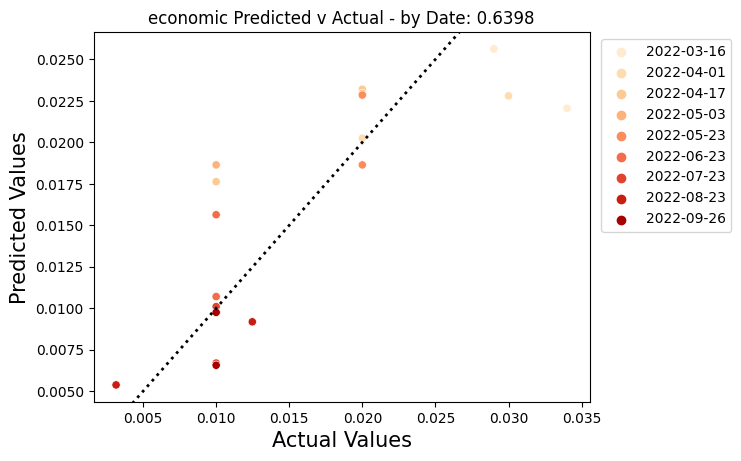

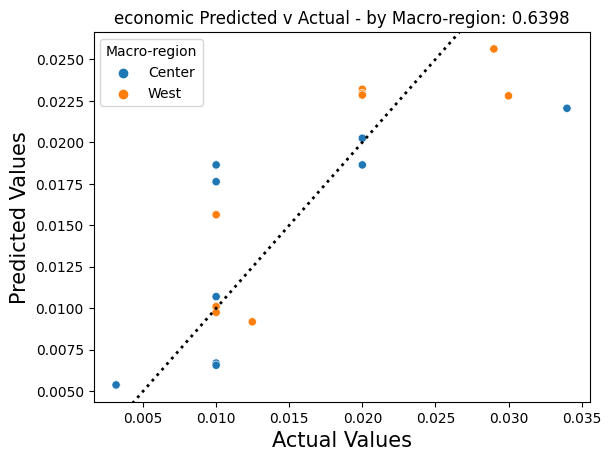




environment

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.026
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.382
Time:                        09:47:33   Log-Likelihood:                 61.901
No. Observations:                  18   AIC:                            -117.8
Df Residuals:                      15   BIC:                            -115.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0556      0.052    

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


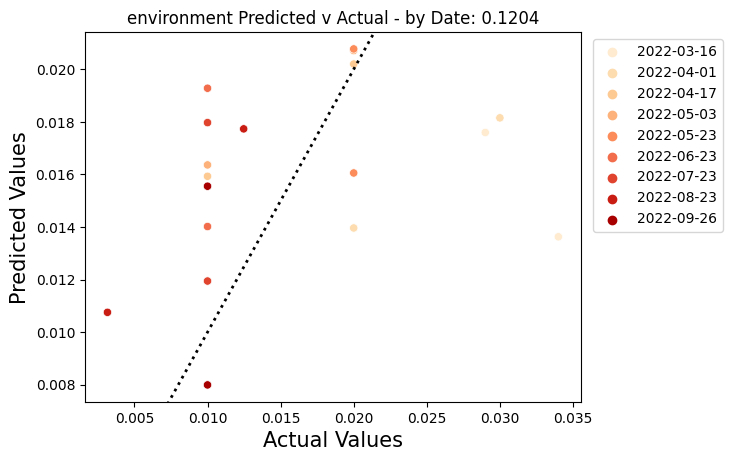

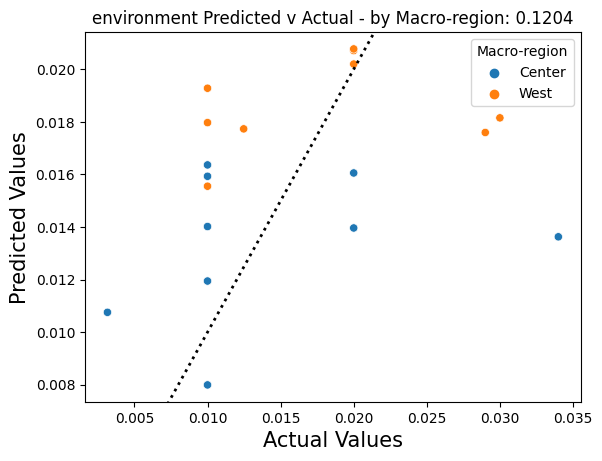




physical

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     1.692
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.218
Time:                        09:47:34   Log-Likelihood:                 62.577
No. Observations:                  18   AIC:                            -119.2
Df Residuals:                      15   BIC:                            -116.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0021      0.001     -1

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


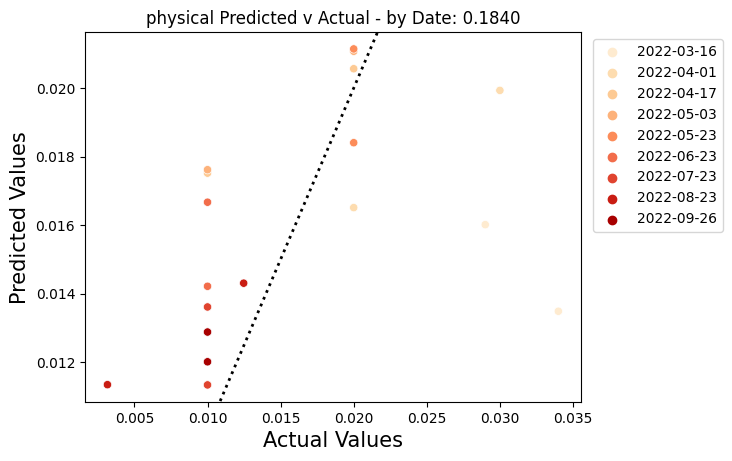

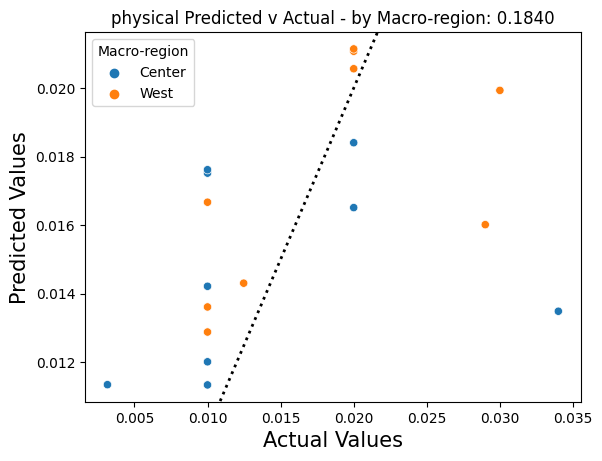




political

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.146
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.344
Time:                        09:47:35   Log-Likelihood:                 62.027
No. Observations:                  18   AIC:                            -118.1
Df Residuals:                      15   BIC:                            -115.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0040      0.003     -

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


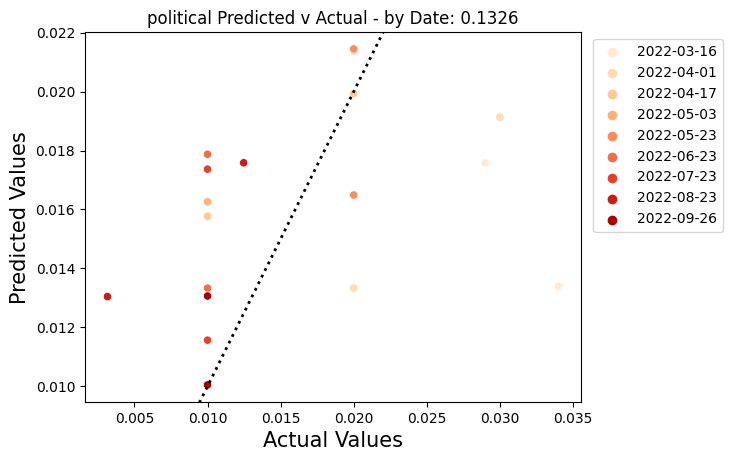

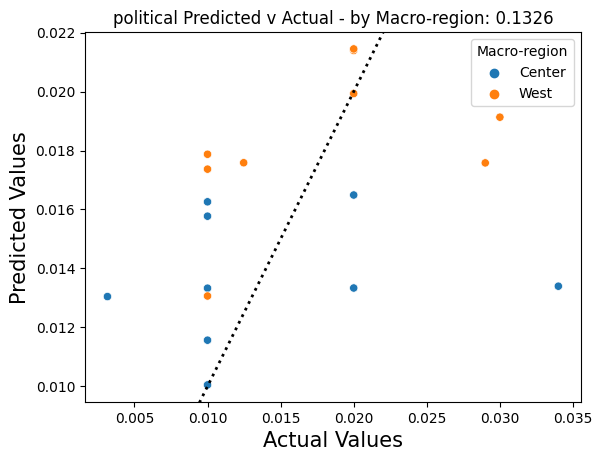




religion

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     3.529
Date:                Wed, 12 Apr 2023   Prob (F-statistic):             0.0554
Time:                        09:47:35   Log-Likelihood:                 64.218
No. Observations:                  18   AIC:                            -122.4
Df Residuals:                      15   BIC:                            -119.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0199      0.008     -2

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


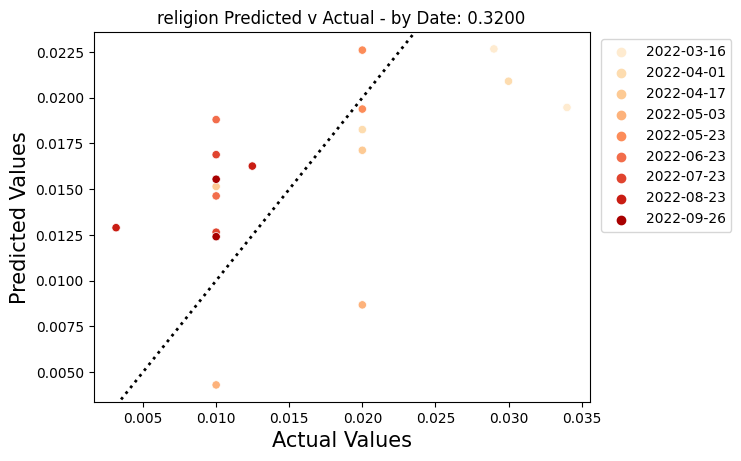

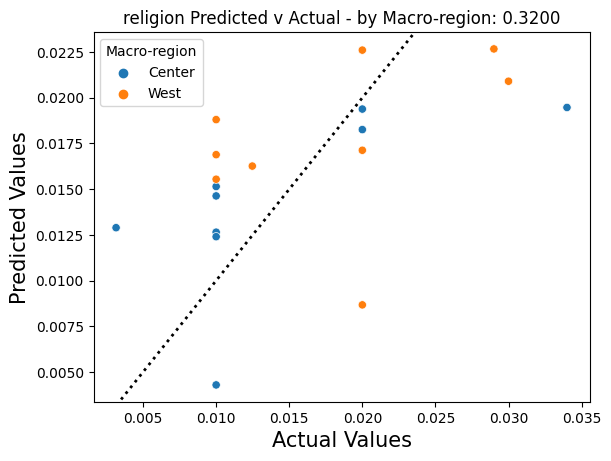




travel

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.8701
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.439
Time:                        09:47:36   Log-Likelihood:                 61.735
No. Observations:                  18   AIC:                            -117.5
Df Residuals:                      15   BIC:                            -114.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0073      0.008     -0.9

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


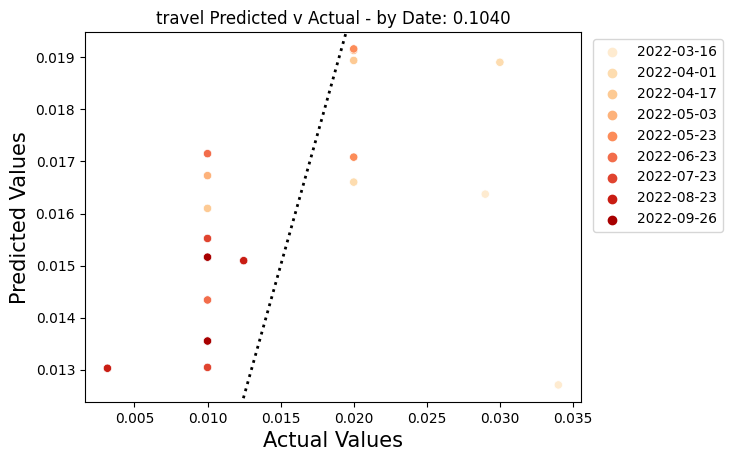

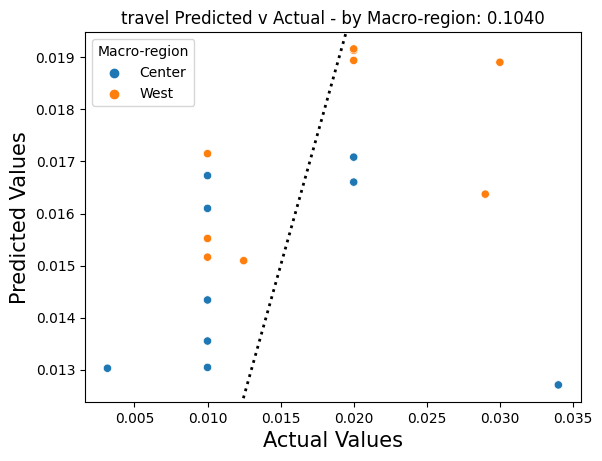




health

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     6.400
Date:                Wed, 12 Apr 2023   Prob (F-statistic):            0.00978
Time:                        09:47:36   Log-Likelihood:                 66.300
No. Observations:                  18   AIC:                            -126.6
Df Residuals:                      15   BIC:                            -123.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0161      0.005     -3.3

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


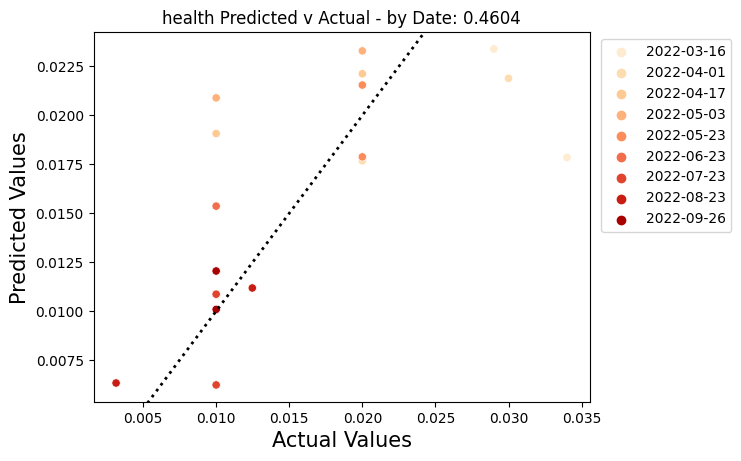

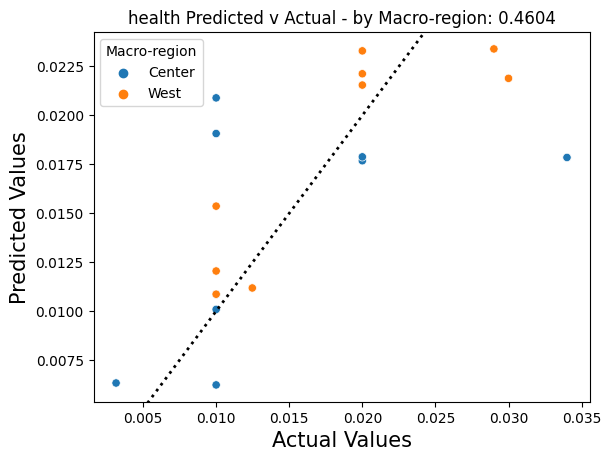




food

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     13.90
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           0.000384
Time:                        09:47:38   Log-Likelihood:                 70.183
No. Observations:                  18   AIC:                            -134.4
Df Residuals:                      15   BIC:                            -131.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0067      0.001     -5.053

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


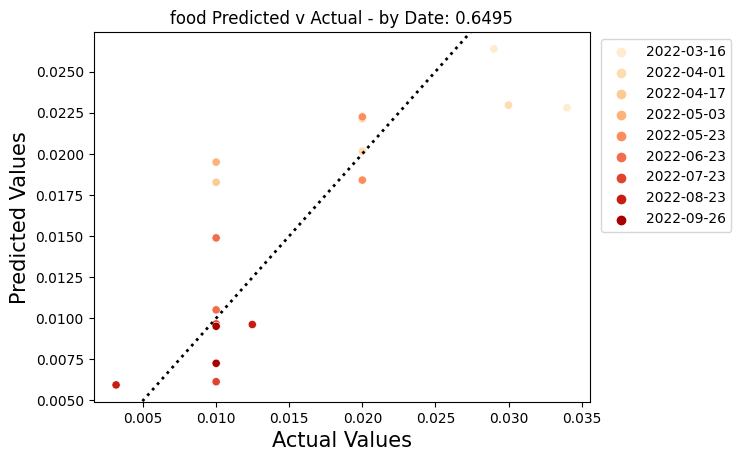

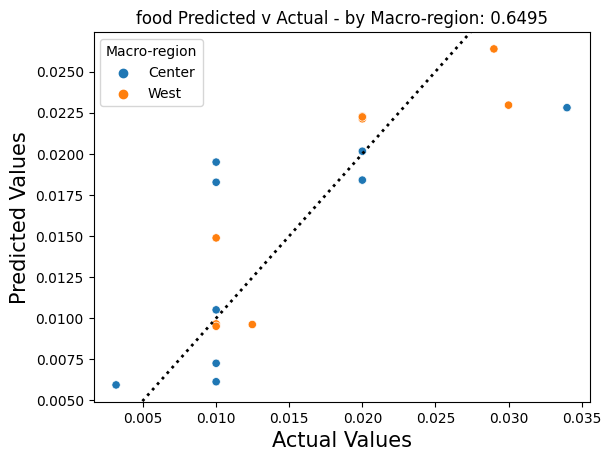

In [21]:
rsquared_list = []

final_df_WC = final_df[(final_df['Macro-region'] == 'West') | (final_df['Macro-region'] == 'Center')]
unhcr_df_WC = unhcr_df[(unhcr_df['Macro-region'] == 'West') | (unhcr_df['Macro-region'] == 'Center')]

# build regression model for each GDELT events variable
for column in final_df_WC.columns[0:8]:
    
    
    Y = np.asarray(unhcr_df_WC['Percent'].astype(float))
    X = np.asarray(final_df_WC[[column]].astype(float))
    
    # build model without dummy variables
    #X = sm.add_constant(X)
    
    
    # dummy variables for macroregion - drop_first = True
    X = np.concatenate([X, pd.get_dummies(unhcr_df_WC['Macro-region'])], axis=1)
    
    model = sm.OLS(Y, X)
    #Fitting model
    results = model.fit()
    #Saving the r_square value
    rsquared_list.append(results.rsquared)
    
    print(column + "\n")
    print(results.summary())
    print("\n")
    print('R-squared: ', results.rsquared)
    print("\n")
    
    # predictions vs actual values plot, colored by date
    predictions = results.predict(pd.concat([final_df_WC[[column]], pd.get_dummies(unhcr_df_WC['Macro-region'])], axis=1))
    plt.title(column + " Predicted v Actual - by Date: " + str('%.4f'%(results.rsquared)))
    plt.xlabel('Actual Values', fontsize=15)
    plt.ylabel('Predicted Values', fontsize=15)
    sns.scatterplot(x=unhcr_df_WC['Percent'], y=predictions, hue=unhcr_df_WC['date_to'].dt.date, palette='OrRd') # add style=unhcr_df['Macro-region'] for shape by Macro-region or vice versa
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
    #plt.scatter(unhcr_df['Percent'], predictions, c=unhcr_df.date_to, cmap='OrRd')
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    # predictions vs actual values plot, colored by Macro-region
    plt.title(column + " Predicted v Actual - by Macro-region: " + str('%.4f'%(results.rsquared)))
    plt.xlabel('Actual Values', fontsize=15)
    plt.ylabel('Predicted Values', fontsize=15)
    #colors = {'Kyiv':'red', 'East':'green', 'South':'blue', 'Center':'yellow', 'North':'purple', 'West':'orange'}
    #plt.scatter(unhcr_df['Percent'], predictions, c=unhcr_df['Macro-region'].map(colors))
    sns.scatterplot(x=unhcr_df_WC['Percent'], y=predictions, hue=unhcr_df_WC['Macro-region'])
    #plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
    #g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    #plt.legend(['Kyiv','East','South','Center','North','West'])
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    print("\n\n")

### Lag/lead with dummy variables

In [22]:
r_squared_df_dummy = pd.DataFrame(columns=['lag',
                                 'variable',
                                 'r_squared'])

for i in range(-24,25):
    temp_df = lag_df[lag_df['lag']==i]
    for column in lag_df.columns[0:8]:
        Y = np.asarray(unhcr_df['Percent'].astype(float))
        X = np.asarray(final_df[[column]].astype(float))
        X = np.concatenate([X, pd.get_dummies(unhcr_df['Macro-region'])], axis=1)
        model = sm.OLS(Y, X)
        fit = model.fit()
        r_squared_df_dummy.loc[len(r_squared_df_dummy.index)] = [i, column, fit.rsquared]

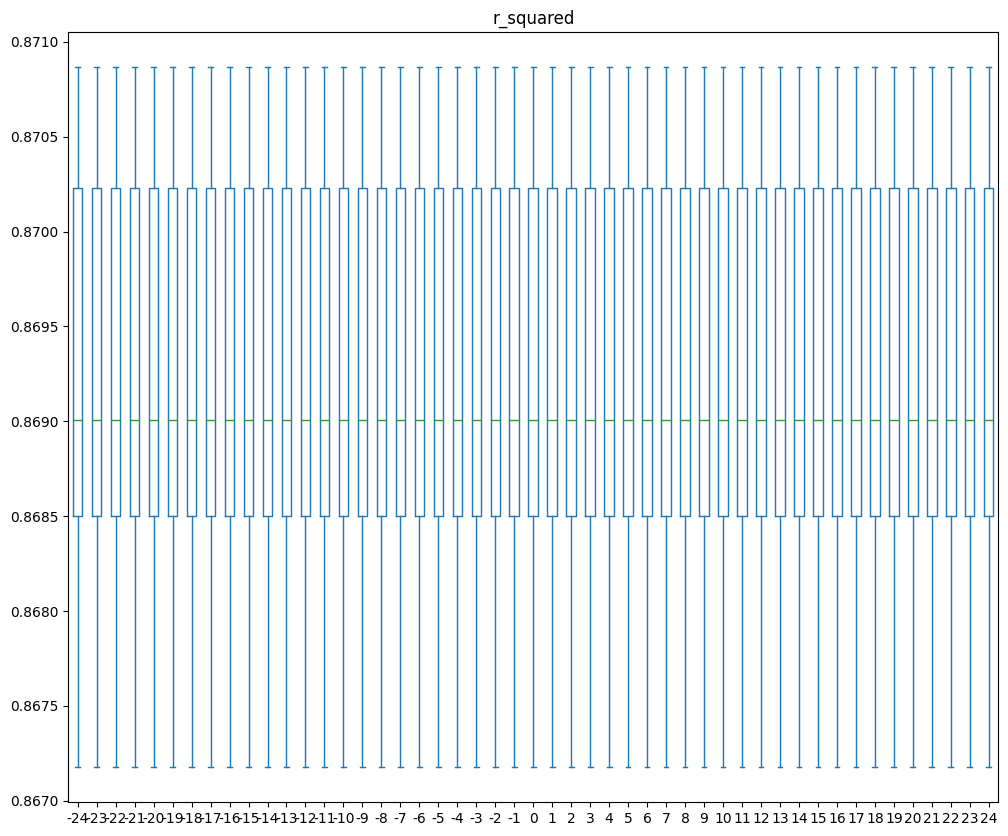

In [23]:
# Create boxplots caapturing how r-squared values vary across lag/lead values
ax = r_squared_df_dummy.plot.box(by="lag", figsize=(12, 10))

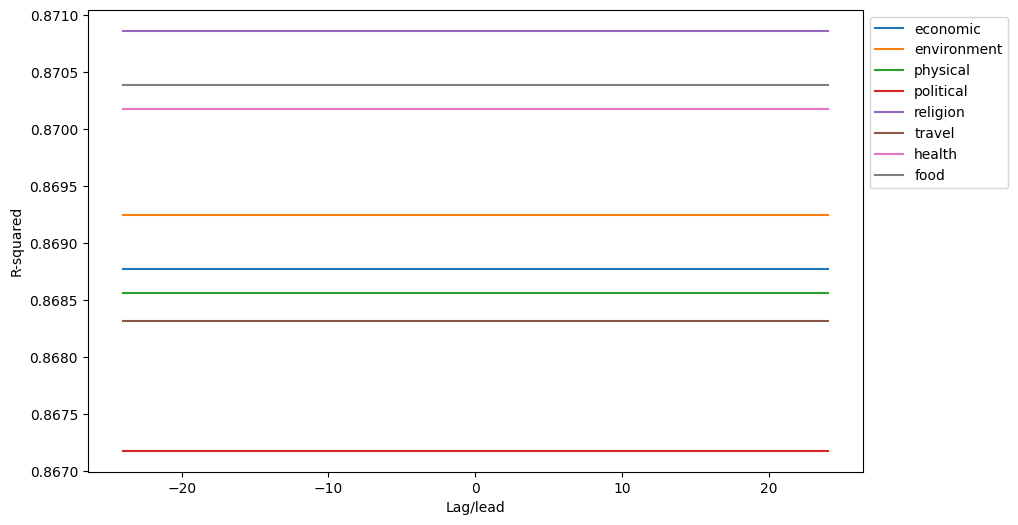

In [24]:
# Lag/lead line plot: how each variable varies across lag values
plt.figure(figsize=(10,6))
for column in lag_df.columns[0:8]:
    temp_df = r_squared_df_dummy[r_squared_df_dummy['variable']==column]
    plt.plot(temp_df['lag'], temp_df['r_squared'], label=column)
   
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Lag/lead")
plt.ylabel("R-squared")
plt.show()